# Bagging Exercises

## Introduction

We will be using the customer churn data from the telecom industry for this week's exercises. The data file is called `Orange_Telecom_Churn_Data.csv`. 

Rotatividade de clientes

In [9]:
from __future__ import print_function
import os
data_path = ['data']

## Question 1

* Import the data from the file `Orange_Telecom_Churn_Data.csv` and examine the shape and data types. For the data types, there will be too many to list each column separately. Rather, aggregate the types by count.
* Determine if the float columns need to be scaled.
* Remove any columns that are likely not to be used for prediction.
* Encode data types as appropriate.

In [10]:
import pandas as pd
import numpy as np

filepath = os.sep.join(data_path + ['Orange_Telecom_Churn_Data.csv'])
data = pd.read_csv(filepath, sep=',')

In [11]:
data.head().T

,0,1,2,3,4
state,KS,OH,NJ,OH,OK
account_length,128,107,137,84,75
area_code,415,415,415,408,415
phone_number,382-4657,371-7191,358-1921,375-9999,330-6626
intl_plan,no,no,no,yes,yes
voice_mail_plan,yes,yes,no,no,no
number_vmail_messages,25,26,0,0,0
total_day_minutes,265.1,161.6,243.4,299.4,166.7
total_day_calls,110,123,114,71,113
total_day_charge,45.07,27.47,41.38,50.9,28.34


The prediction should definitely not include phone number. And it is unlikely that area code or state would be desired, unless there is some reason to assume the model has a very specific geographic factor.

In [12]:
data.drop(['state', 'phone_number', 'area_code'], axis=1, inplace=True)

Nem todos os valores são números inteiros ou valores flutuantes, portanto realizaremos alterações para que sejam.

In [13]:
data.dtypes

account_length                     int64
intl_plan                         object
voice_mail_plan                   object
number_vmail_messages              int64
total_day_minutes                float64
total_day_calls                    int64
total_day_charge                 float64
total_eve_minutes                float64
total_eve_calls                    int64
total_eve_charge                 float64
total_night_minutes              float64
total_night_calls                  int64
total_night_charge               float64
total_intl_minutes               float64
total_intl_calls                   int64
total_intl_charge                float64
number_customer_service_calls      int64
churned                             bool
dtype: object

In [14]:
for col in ['intl_plan', 'voice_mail_plan']:
    data[col] = data[col].replace('yes','True').replace('no','False').astype(bool)
    
    
data[['intl_plan', 'voice_mail_plan']].dtypes

intl_plan          bool
voice_mail_plan    bool
dtype: object

## Question 2

* Integer encode the activities.
* Split the data into train and test data sets. Decide if the data will be stratified or not during the train/test split.

In [15]:
data.churned.value_counts()

churned
False    4293
True      707
Name: count, dtype: int64

In [16]:
data.churned.value_counts(normalize=True)

churned
False    0.8586
True     0.1414
Name: proportion, dtype: float64

Percebe-se que os dados são desviados em média em 86% para os clientes não cancelados.

Ao fazer a transformação, teremos o seguinte enconder:

0 - churned

1 - not churned

In [17]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()

data['churned'] = le.fit_transform(data['churned'])

le.classes_

array([False,  True])

**NOTE**: We are about to create training and test sets from `data`. On those datasets, we are going to run grid searches over many choices of parameters. This can take some time. In order to shorten the grid search time, feel free to downsample `data` and create `X_train, X_test, y_train, y_test` from the downsampled dataset.

Now split the data into train and test data sets. A stratified split was not used here. If there are issues with any of the error metrics on the test set, it can be a good idea to start model fitting over using a stratified split. Boosting is a pretty powerful model, though, so it may not be necessary in this case.

In [18]:
from sklearn.model_selection import train_test_split

# Alternatively, we could stratify the categories in the split, as was done previously
feature_columns = [x for x in data.columns if x != 'churned']

X_train, X_test, y_train, y_test = train_test_split(data[feature_columns], data['churned'],
                 test_size=0.3, random_state=42)

In [33]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((3500, 17), (3500,), (1500, 17), (1500,))

In [34]:
y_train.value_counts(normalize=True)

churned
0    0.857143
1    0.142857
Name: proportion, dtype: float64

In [35]:
y_test.value_counts(normalize=True)

churned
0    0.862
1    0.138
Name: proportion, dtype: float64

## Question 3

* Fit random forest models with a range of tree numbers and evaluate the out-of-bag error for each of these models.
* Plot the resulting oob errors as a function of the number of trees.

*Hint:* since the only thing changing is the number of trees, the `warm_start` flag can be used so that the model just adds more trees to the existing model each time. Use the `set_params` method to update the number of trees.

In [21]:
# Suppress warnings about too few trees from the early models

import warnings
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)

In [22]:
from sklearn.ensemble import RandomForestClassifier

# Initialize the random forest estimator
# Note that the number of trees is not setup here
RF = RandomForestClassifier(oob_score=True, 
                            random_state=42, 
                            warm_start=True,
                            n_jobs=-1)

oob_list = list()

# Iterate through all of the possibilities for 
# number of trees
for n_trees in [15, 20, 30, 40, 50, 100, 150, 200, 300, 400]:
    
    # Use this to set the number of trees
    RF.set_params(n_estimators=n_trees)

    # Fit the model
    RF.fit(X_train, y_train)

    # Get the oob error
    oob_error = 1 - RF.oob_score_
    
    # Store it
    oob_list.append(pd.Series({'n_trees': n_trees, 'oob': oob_error}))

rf_oob_df = pd.concat(oob_list, axis=1).T.set_index('n_trees')

rf_oob_df

,oob
n_trees,
15.0,0.088571
20.0,0.084286
30.0,0.079714
40.0,0.078000
50.0,0.075714
100.0,0.072000
150.0,0.073143
200.0,0.072000
300.0,0.070857


The error looks like it has stabilized around 100-150 trees.

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

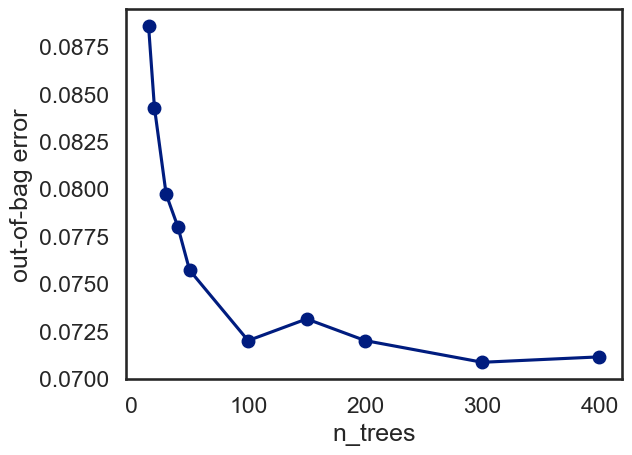

In [24]:
sns.set_context('talk')
sns.set_palette('dark')
sns.set_style('white')

ax = rf_oob_df.plot(legend=False, marker='o')
ax.set(ylabel='out-of-bag error');

## Question 4

* Repeat question 3 using extra randomized trees (`ExtraTreesClassifier`). Note that the `bootstrap` parameter will have to be set to `True` for this model.
* Compare the out-of-bag errors for the two different types of models.

In [25]:
from sklearn.ensemble import ExtraTreesClassifier

# Initialize the random forest estimator
# Note that the number of trees is not setup here
EF = ExtraTreesClassifier(oob_score=True, 
                          random_state=42, 
                          warm_start=True,
                          bootstrap=True,
                          n_jobs=-1)

oob_list = list()

# Iterate through all of the possibilities for 
# number of trees
for n_trees in [15, 20, 30, 40, 50, 100, 150, 200, 300, 400]:
    
    # Use this to set the number of trees
    EF.set_params(n_estimators=n_trees)
    EF.fit(X_train, y_train)

    # oob error
    oob_error = 1 - EF.oob_score_
    oob_list.append(pd.Series({'n_trees': n_trees, 'oob': oob_error}))

et_oob_df = pd.concat(oob_list, axis=1).T.set_index('n_trees')

et_oob_df

,oob
n_trees,
15.0,0.098000
20.0,0.093143
30.0,0.083714
40.0,0.080286
50.0,0.080000
100.0,0.079143
150.0,0.080286
200.0,0.078286
300.0,0.079429


Combine the two dataframes into a single one for easier plotting.

In [26]:
oob_df = pd.concat([rf_oob_df.rename(columns={'oob':'RandomForest'}),
                    et_oob_df.rename(columns={'oob':'ExtraTrees'})], axis=1)

oob_df

,RandomForest,ExtraTrees
n_trees,,
15.0,0.088571,0.098000
20.0,0.084286,0.093143
30.0,0.079714,0.083714
40.0,0.078000,0.080286
50.0,0.075714,0.080000
100.0,0.072000,0.079143
150.0,0.073143,0.080286
200.0,0.072000,0.078286
300.0,0.070857,0.079429


The random forest model performs consistently better than the extra randomized trees.

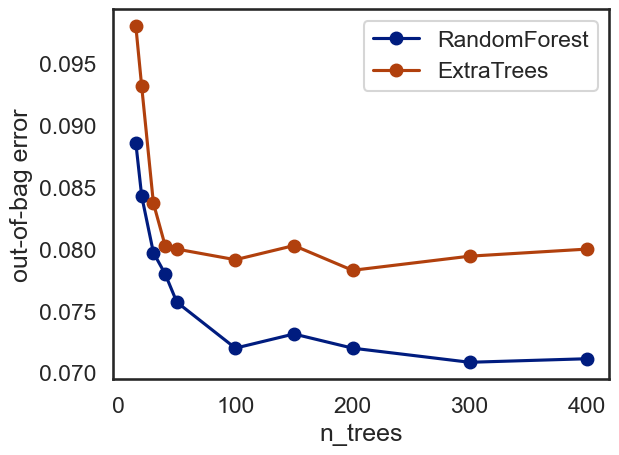

In [27]:
sns.set_context('talk')
sns.set_palette('dark')
sns.set_style('white')

ax = oob_df.plot(marker='o')
ax.set(ylabel='out-of-bag error');

## Question 5

* Select one of the models that performs well and calculate error metrics and a confusion matrix on the test data set. 
* Given the distribution of the predicted class, which metric is most important? Which could be deceiving?

In [28]:
# Random forest with 100 estimators
model = RF.set_params(n_estimators=100)

y_pred = model.predict(X_test)

Unsurprisingly, recall is rather poor for the customers who churned (True) class since they are quite small. We are doing better than random guessing, though, as the accuracy is 0.932 (vs 0.85 for random guessing).

In [29]:
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score
from sklearn.metrics import f1_score, roc_auc_score

cr = classification_report(y_test, y_pred)
print(cr)

score_df = pd.DataFrame({'accuracy': accuracy_score(y_test, y_pred),
                         'precision': precision_score(y_test, y_pred),
                         'recall': recall_score(y_test, y_pred),
                         'f1': f1_score(y_test, y_pred),
                         'auc': roc_auc_score(y_test, y_pred)},
                         index=pd.Index([0]))

print(score_df)

              precision    recall  f1-score   support

           0       0.93      0.99      0.96      1293
           1       0.91      0.52      0.66       207

    accuracy                           0.93      1500
   macro avg       0.92      0.76      0.81      1500
weighted avg       0.93      0.93      0.92      1500

   accuracy  precision    recall        f1       auc
0  0.926667   0.907563  0.521739  0.662577  0.756616


## Question 6

* Print or visualize the confusion matrix.
* Plot the ROC-AUC and precision-recall curves.
* Plot the feature importances.

Text(0.5, 9.883333333333328, 'Prediction')

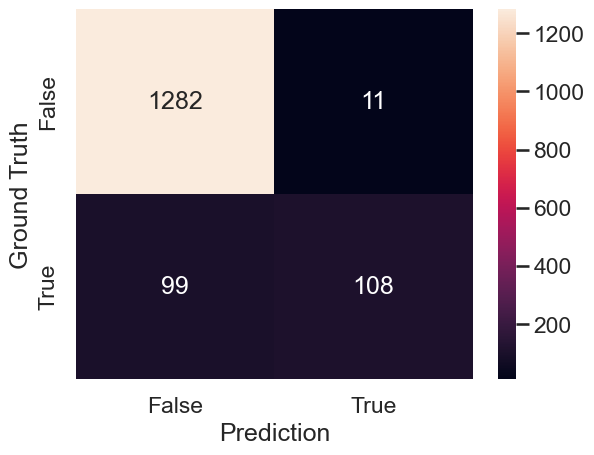

In [30]:
from sklearn.metrics import roc_curve, precision_recall_curve, confusion_matrix

sns.set_context('talk')
cm = confusion_matrix(y_test, y_pred)
ax = sns.heatmap(cm, annot=True, fmt='d')

labels = ['False', 'True']
ax.set_xticklabels(labels);
ax.set_yticklabels(labels);
ax.set_ylabel('Ground Truth');
ax.set_xlabel('Prediction')

The ROC-AUC and precision-recall curves.

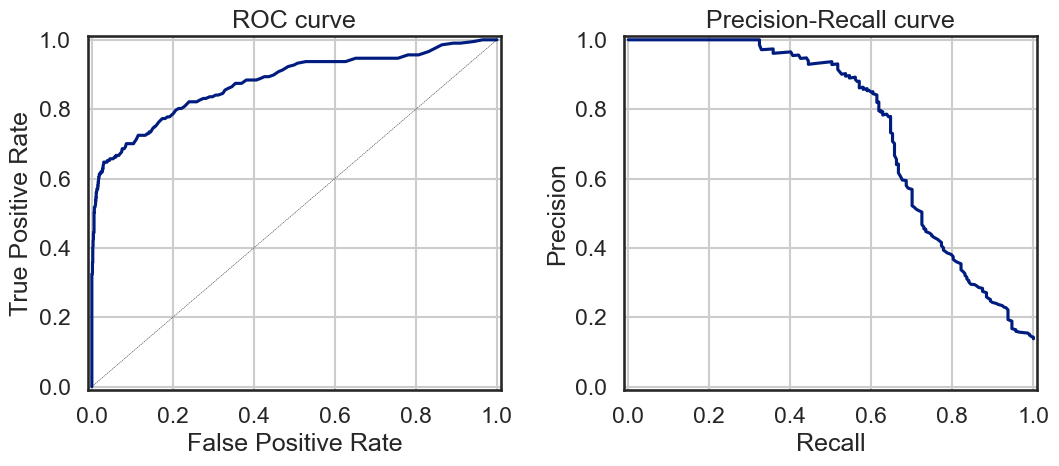

In [31]:
sns.set_context('talk')

fig, axList = plt.subplots(ncols=2)
fig.set_size_inches(11, 5)

# Get the probabilities for each of the two categories
y_prob = model.predict_proba(X_test)

# Plot the ROC-AUC curve
ax = axList[0]

fpr, tpr, thresholds = roc_curve(y_test, y_prob[:,1])
ax.plot(fpr, tpr)
# It is customary to draw a diagonal dotted line in ROC plots.
# This is to indicate completely random prediction. Deviation from this
# dotted line towards the upper left corner signifies the power of the model.
ax.plot([0, 1], [0, 1], ls='--', color='black', lw=.3)
ax.set(xlabel='False Positive Rate',
       ylabel='True Positive Rate',
       xlim=[-.01, 1.01], ylim=[-.01, 1.01],
       title='ROC curve')
ax.grid(True)

# Plot the precision-recall curve
ax = axList[1]

precision, recall, _ = precision_recall_curve(y_test, y_prob[:,1])
ax.plot(recall, precision)
ax.set(xlabel='Recall', ylabel='Precision',
       xlim=[-.01, 1.01], ylim=[-.01, 1.01],
       title='Precision-Recall curve')
ax.grid(True)

plt.tight_layout()

The feature importances. Total daily cost is the biggest predictor of customer churn.

In [32]:
feature_imp = pd.Series(model.feature_importances_, index=feature_cols).sort_values(ascending=False)

ax = feature_imp.plot(kind='bar')
ax.set(ylabel='Relative Importance');

NameError: name 'feature_cols' is not defined

# Analise

* Como esperado, ao analisar os dois métodos utilizados (RandomForest e ExtraRandomForest) para a classificação dos dados, nota-se que o RandomForest obteve um erro inferior ao ExtraRandomForest, que é o esperado. O resultado obtido pelo RandomForest se estabilizou por volta das 150 árvores, isto é, mesmo que tenhamos um número muito grande de samples, o valor do erro não diminuirá

* Um outro ponto a se notar, é que o RandomForest teve dificuldade para identificar valores `True`, visto que os Falsos Positivos foram bem próximos em relação ao valor obtido nos realmente verdadeiros.

* Ao olhar a curva AUC, nota-se que, mesmo que o sistema tenha tido dificuldades para se identificar valores `True`, o sistema conseguiu identificar valores `False` com uma precisão muito boa, visto que a curva AUC está próxima de 1. Não só isso, mas a partir da curva Precision Recall, é possível notar que na maior parte dos valores de recall, o sistema continua com uma precisão muito boa, o que é um ponto positivo para este problema em questão.

* Por fim, ao olhar o gráfico relativo à importância das features, nota-se que a feature `total_day_charge` é a que mais influencia na classificação dos dados, o que faz sentido, visto que, se o cliente está gastando muito dinheiro, é provável que ele esteja insatisfeito com o serviço.